In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic'
)
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({"font.size" : 10, 
                     "font.family" : 'NanumGothic',
                     "axes.unicode_minus" : False})
plt.rc("font", family = 'NanumGothic')
import seaborn as sns
from pathlib import Path

In [2]:
DATA = Path("../../data")

In [3]:
train = pd.read_csv(DATA / "fog_train_knn-imputate.csv")
test = pd.read_csv(DATA / "fog_test_01.csv")

In [4]:
train

,년도,월,일,시간,분,년월일시분,지점번호,10분평균풍향,10분평균풍속,10분평균기온,10분평균상대습도,10분일사량합,10분평균지면온도,10분평균시정,시정구간,강수유무,NaN유무
0,I,1,1,0,10,2020-01-01 00:10:00,AA,0.0,0.0,-6.4,38.9,0.0,-2.8,20000.0,4,0,0
1,I,1,1,0,20,2020-01-01 00:20:00,AA,0.0,0.0,-6.3,37.9,0.0,-2.7,20000.0,4,0,0
2,I,1,1,0,30,2020-01-01 00:30:00,AA,0.0,0.0,-6.3,40.0,0.0,-2.6,20000.0,4,0,0
3,I,1,1,0,40,2020-01-01 00:40:00,AA,27.8,0.4,-6.2,39.5,0.0,-2.6,20000.0,4,0,0
4,I,1,1,0,50,2020-01-01 00:50:00,AA,59.7,0.5,-6.1,39.8,0.0,-2.5,20000.0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,K,12,31,23,10,2022-12-31 23:10:00,EC,305.3,7.7,2.5,50.2,0.0,-0.9,20000.0,4,0,0
3156456,K,12,31,23,20,2022-12-31 23:20:00,EC,293.8,5.7,2.3,50.1,0.0,-1.3,20000.0,4,0,0
3156457,K,12,31,23,30,2022-12-31 23:30:00,EC,274.2,4.9,2.2,51.0,0.0,-1.4,20000.0,4,0,0
3156458,K,12,31,23,40,2022-12-31 23:40:00,EC,270.3,4.6,2.1,51.7,0.0,-1.6,20000.0,4,0,0


In [5]:
test

,년도,월,일,시간,분,지점번호,10분평균풍향,10분평균풍속,10분평균기온,강수유무,10분평균상대습도,10분일사량합,10분평균지면온도,시정구간
0,L,1,1,0,0,AI,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN
1,L,1,1,0,10,AI,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN
2,L,1,1,0,20,AI,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN
3,L,1,1,0,30,AI,323.6,0.7,-2.6,0.0,88.7,0.0,-1.6,NaN
4,L,1,1,0,40,AI,208.4,0.2,-2.6,0.0,89.0,0.0,-1.6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262795,L,12,31,23,10,ED,338.8,6.1,4.5,0.0,71.3,0.0,1.9,NaN
262796,L,12,31,23,20,ED,335.2,5.8,4.6,0.0,71.4,0.0,1.9,NaN
262797,L,12,31,23,30,ED,337.1,5.3,4.5,0.0,72.1,0.0,1.8,NaN
262798,L,12,31,23,40,ED,322.0,3.7,4.3,0.0,72.5,0.0,1.4,NaN


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
train_df = train.loc[:, ["년도", "10분평균풍향", "10분평균풍속", "10분평균기온", "10분평균상대습도", "10분일사량합", "10분평균지면온도", "강수유무", "10분평균시정"]]
test_df = test.loc[:, ["10분평균풍향", "10분평균풍속", "10분평균기온", "10분평균상대습도", "10분일사량합", "10분평균지면온도", "강수유무"]]

In [8]:
train_df

,년도,10분평균풍향,10분평균풍속,10분평균기온,10분평균상대습도,10분일사량합,10분평균지면온도,강수유무,10분평균시정
0,I,0.0,0.0,-6.4,38.9,0.0,-2.8,0,20000.0
1,I,0.0,0.0,-6.3,37.9,0.0,-2.7,0,20000.0
2,I,0.0,0.0,-6.3,40.0,0.0,-2.6,0,20000.0
3,I,27.8,0.4,-6.2,39.5,0.0,-2.6,0,20000.0
4,I,59.7,0.5,-6.1,39.8,0.0,-2.5,0,20000.0
...,...,...,...,...,...,...,...,...,...
3156455,K,305.3,7.7,2.5,50.2,0.0,-0.9,0,20000.0
3156456,K,293.8,5.7,2.3,50.1,0.0,-1.3,0,20000.0
3156457,K,274.2,4.9,2.2,51.0,0.0,-1.4,0,20000.0
3156458,K,270.3,4.6,2.1,51.7,0.0,-1.6,0,20000.0


In [9]:
test_df

,10분평균풍향,10분평균풍속,10분평균기온,10분평균상대습도,10분일사량합,10분평균지면온도,강수유무
0,329.5,0.6,-2.5,87.5,0.0,-1.6,0.0
1,321.8,1.2,-2.5,88.2,0.0,-1.6,0.0
2,0.4,0.4,-2.5,88.6,0.0,-1.7,0.0
3,323.6,0.7,-2.6,88.7,0.0,-1.6,0.0
4,208.4,0.2,-2.6,89.0,0.0,-1.6,0.0
...,...,...,...,...,...,...,...
262795,338.8,6.1,4.5,71.3,0.0,1.9,0.0
262796,335.2,5.8,4.6,71.4,0.0,1.9,0.0
262797,337.1,5.3,4.5,72.1,0.0,1.8,0.0
262798,322.0,3.7,4.3,72.5,0.0,1.4,0.0


In [10]:
# min-max scaler

from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_cols = ["10분평균풍향", "10분평균풍속", "10분평균기온", "10분평균상대습도", "10분일사량합", "10분평균지면온도", "강수유무"]
y_col = "10분평균시정"

train_df.loc[:, X_cols] = X_scaler.fit_transform(train_df[X_cols])
train_df.loc[:, y_col] = y_scaler.fit_transform(train_df[y_col].to_frame())
test_df.loc[:, X_cols] = X_scaler.transform(test_df[X_cols])

In [11]:
train_df

,년도,10분평균풍향,10분평균풍속,10분평균기온,10분평균상대습도,10분일사량합,10분평균지면온도,강수유무,10분평균시정
0,I,0.000000,0.000000,0.288245,0.389,0.0,0.028000,0,0.330431
1,I,0.000000,0.000000,0.289855,0.379,0.0,0.029333,0,0.330431
2,I,0.000000,0.000000,0.289855,0.400,0.0,0.030667,0,0.330431
3,I,0.077222,0.017778,0.291465,0.395,0.0,0.030667,0,0.330431
4,I,0.165833,0.022222,0.293076,0.398,0.0,0.032000,0,0.330431
...,...,...,...,...,...,...,...,...,...
3156455,K,0.848056,0.342222,0.431562,0.502,0.0,0.053333,0,0.330431
3156456,K,0.816111,0.253333,0.428341,0.501,0.0,0.048000,0,0.330431
3156457,K,0.761667,0.217778,0.426731,0.510,0.0,0.046667,0,0.330431
3156458,K,0.750833,0.204444,0.425121,0.517,0.0,0.044000,0,0.330431


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3156460 entries, 0 to 3156459
Data columns (total 9 columns):
 #   Column     Dtype  
---  ------     -----  
 0   년도         object 
 1   10분평균풍향    float64
 2   10분평균풍속    float64
 3   10분평균기온    float64
 4   10분평균상대습도  float64
 5   10분일사량합    float64
 6   10분평균지면온도  float64
 7   강수유무       int64  
 8   10분평균시정    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 216.7+ MB


In [13]:
test_df

,10분평균풍향,10분평균풍속,10분평균기온,10분평균상대습도,10분일사량합,10분평균지면온도,강수유무
0,0.915278,0.026667,0.351047,0.875,0.0,0.044000,0.0
1,0.893889,0.053333,0.351047,0.882,0.0,0.044000,0.0
2,0.001111,0.017778,0.351047,0.886,0.0,0.042667,0.0
3,0.898889,0.031111,0.349436,0.887,0.0,0.044000,0.0
4,0.578889,0.008889,0.349436,0.890,0.0,0.044000,0.0
...,...,...,...,...,...,...,...
262795,0.941111,0.271111,0.463768,0.713,0.0,0.090667,0.0
262796,0.931111,0.257778,0.465378,0.714,0.0,0.090667,0.0
262797,0.936389,0.235556,0.463768,0.721,0.0,0.089333,0.0
262798,0.894444,0.164444,0.460548,0.725,0.0,0.084000,0.0


In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262800 entries, 0 to 262799
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   10분평균풍향    262576 non-null  float64
 1   10분평균풍속    262576 non-null  float64
 2   10분평균기온    262709 non-null  float64
 3   10분평균상대습도  262743 non-null  float64
 4   10분일사량합    262685 non-null  float64
 5   10분평균지면온도  255157 non-null  float64
 6   강수유무       258297 non-null  float64
dtypes: float64(7)
memory usage: 14.0 MB


In [15]:
# Holdout (I,J : K)

train_data = train_df.query("년도!='K'").iloc[:, 1:]
valid_data = train_df.query("년도=='K'").iloc[:, 1:]

In [16]:
train_data

,10분평균풍향,10분평균풍속,10분평균기온,10분평균상대습도,10분일사량합,10분평균지면온도,강수유무,10분평균시정
0,0.000000,0.000000,0.288245,0.389,0.0,0.028000,0,0.330431
1,0.000000,0.000000,0.289855,0.379,0.0,0.029333,0,0.330431
2,0.000000,0.000000,0.289855,0.400,0.0,0.030667,0,0.330431
3,0.077222,0.017778,0.291465,0.395,0.0,0.030667,0,0.330431
4,0.165833,0.022222,0.293076,0.398,0.0,0.032000,0,0.330431
...,...,...,...,...,...,...,...,...
3103895,0.868889,0.315556,0.354267,0.474,0.0,0.026667,0,0.330431
3103896,0.875833,0.320000,0.354267,0.463,0.0,0.025333,0,0.330431
3103897,0.876667,0.320000,0.354267,0.455,0.0,0.026667,0,0.330431
3103898,0.867500,0.320000,0.354267,0.446,0.0,0.025333,0,0.330431


In [17]:
valid_data

,10분평균풍향,10분평균풍속,10분평균기온,10분평균상대습도,10분일사량합,10분평균지면온도,강수유무,10분평균시정
105263,0.881944,0.084444,0.254428,0.411,0.000000,0.012444,0,0.330431
105264,0.845556,0.084444,0.252818,0.408,0.003349,0.024889,0,0.330431
105265,0.758889,0.097778,0.251208,0.408,0.000000,0.030444,0,0.330431
105266,0.730000,0.093333,0.247987,0.415,0.000000,0.037333,0,0.330431
105267,0.715000,0.102222,0.246377,0.413,0.000000,0.018667,0,0.330431
...,...,...,...,...,...,...,...,...
3156455,0.848056,0.342222,0.431562,0.502,0.000000,0.053333,0,0.330431
3156456,0.816111,0.253333,0.428341,0.501,0.000000,0.048000,0,0.330431
3156457,0.761667,0.217778,0.426731,0.510,0.000000,0.046667,0,0.330431
3156458,0.750833,0.204444,0.425121,0.517,0.000000,0.044000,0,0.330431


In [19]:
pre_val_data = valid_data.iloc[:6, :].rolling(window=6, min_periods=1).mean().reset_index(drop=True)
valid_data = pd.concat([pre_val_data, valid_data.reset_index(drop=True)], axis=0).reset_index(drop=True)

In [20]:
valid_data

,10분평균풍향,10분평균풍속,10분평균기온,10분평균상대습도,10분일사량합,10분평균지면온도,강수유무,10분평균시정
0,0.881944,0.084444,0.254428,0.4110,0.000000,0.012444,0.0,0.330431
1,0.863750,0.084444,0.253623,0.4095,0.001675,0.018667,0.0,0.330431
2,0.828796,0.088889,0.252818,0.4090,0.001116,0.022593,0.0,0.330431
3,0.804097,0.090000,0.251610,0.4105,0.000837,0.026278,0.0,0.330431
4,0.786278,0.092444,0.250564,0.4110,0.000670,0.024756,0.0,0.330431
...,...,...,...,...,...,...,...,...
1051201,0.848056,0.342222,0.431562,0.5020,0.000000,0.053333,0.0,0.330431
1051202,0.816111,0.253333,0.428341,0.5010,0.000000,0.048000,0.0,0.330431
1051203,0.761667,0.217778,0.426731,0.5100,0.000000,0.046667,0.0,0.330431
1051204,0.750833,0.204444,0.425121,0.5170,0.000000,0.044000,0.0,0.330431


In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"{device} is available")

cpu is available


In [23]:
train_data

,10분평균풍향,10분평균풍속,10분평균기온,10분평균상대습도,10분일사량합,10분평균지면온도,강수유무,10분평균시정
0,0.000000,0.000000,0.288245,0.389,0.0,0.028000,0,0.330431
1,0.000000,0.000000,0.289855,0.379,0.0,0.029333,0,0.330431
2,0.000000,0.000000,0.289855,0.400,0.0,0.030667,0,0.330431
3,0.077222,0.017778,0.291465,0.395,0.0,0.030667,0,0.330431
4,0.165833,0.022222,0.293076,0.398,0.0,0.032000,0,0.330431
...,...,...,...,...,...,...,...,...
3103895,0.868889,0.315556,0.354267,0.474,0.0,0.026667,0,0.330431
3103896,0.875833,0.320000,0.354267,0.463,0.0,0.025333,0,0.330431
3103897,0.876667,0.320000,0.354267,0.455,0.0,0.026667,0,0.330431
3103898,0.867500,0.320000,0.354267,0.446,0.0,0.025333,0,0.330431


In [39]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, window_size=6):
        self.data = np.array(data)
        self.window_size = window_size
        
    def __len__(self):
        return len(self.data) - self.window_size # 2105254
    
    def __getitem__(self, idx):
        X_data = self.data[idx:idx+self.window_size, :-1]
        y_data = np.expand_dims(self.data[idx+self.window_size, -1], axis=-1)
        return torch.tensor(data=X_data, dtype=torch.float32), torch.tensor(data=y_data, dtype=torch.float32)

In [40]:
batch_size = 6 * 24 # 배치 사이즈는 하루 단위로 설정
window_size = 6 # 60분을 보고 다음 10분을 예측하므로 총 window_size는 6

train_dataset = CustomDataset(data=train_data, window_size=window_size) # window_size는 default 6 (1시간 단위)
valid_dataset = CustomDataset(data=valid_data, window_size=window_size) # 검증을 위한 window_size는 보통 1로 두고 추론

In [41]:
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) # 시계열 데이터라서 shuffle은 함부로 하면 안됨
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False) # 시계열 데이터라서 shuffle은 함부로 하면 안됨

In [112]:
len(train_data_loader)

14620

In [42]:
for X, y in train_data_loader:
    print(X.shape, y.shape)
    break
# (batch size, time step, feature dimension) 

torch.Size([144, 6, 7]) torch.Size([144, 1])


In [113]:
for X, y in valid_data_loader:
    print(X.shape, y.shape)
    break
# (batch size, time step, feature dimension) 

torch.Size([144, 6, 7]) torch.Size([144, 1])


In [29]:
# 모델링 파라미터 정의

input_size = len(X_cols) # 입력 특성 개수(target columns 만큼 특성이 들어감)
num_layers = 2 # Hidden Layer의 개수 간단하게 two-layer로 구현 (추후 더 복잡하게 변경할 수 있음)
hidden_size = 7 # Hidden Layer의 크기 (크면 모델의 표현력이 상승하지만 과적합의 위험이 존재함 -> 모델의 복잡성과 데이터의 복잡성을 고려해야함 = 실험적으로 찾아야함)

In [30]:
# 모델링

""" VanillaRNN """

class VanillaRNN(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size, window_size, device):
        super(VanillaRNN, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.window_size = window_size
        self.rnn = nn.RNN(input_size=input_size, 
                          hidden_size=hidden_size, 
                          num_layers=num_layers, 
                          batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size * window_size, batch_size),
                                nn.ReLU(),
                                nn.Linear(batch_size, 1))
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정
        out, _ = self.rnn(x, h0) # rnn의 결과로는 해당 state의 output과 해당 hidden state를 지난 후의 상태인 hn을 반환함 여기서는 rnn을 한개만 사용했으므로 hn을 따로 할당할 필요는 없음
        # out1, h1 = self.rnn(x, h0)
        # out2, h2 = self.rnn(x, h1)
        # out3, _ = self.rnn(x, h2) # 이런식으로 현재의 상태를 다음 hidden state에 넘기고 싶을 때 사용함
        # print(out.shape) # torch.Size([144, 6, 512])
        
        out = out.contiguous().view(-1, self.hidden_size) # [batch_size*sequence_length, hidden_size]
        out = self.batch_norm(out) # 배치 정규화
        out = out.view(-1, self.window_size, self.hidden_size) # [batch_size, sequence_length, hidden_size]
        out = self.dropout(out) # dropout 적용
        
        out = out.reshape(out.shape[0], -1)
        # print(out ,out.shape) # torch.Size([144, 3072])
        
        out = self.fc(out)
        return out

In [31]:
model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   window_size=window_size,
                   num_layers=num_layers,
                   device=device).to(device=device)

In [32]:
# RMSLELoss 구현 RMSLE는 outlier에 강건하며 상대적오차를 측정함 또한 예측값이 클 때보다 작을 때 더 큰 패널티 부여함

class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
    
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [33]:
# 학습 파라미터 정의

criterion = nn.MSELoss()
learning_rate = 0.0001 # 학습률은 0.001로 설정
epoch = 100 # 학습 반복 횟수
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", patience=1) # 1에폭마다 Loss가 줄어들지 않으면 학습률을 감소시킴

In [34]:
# 기울기 클리핑 함수 : 기울기 소실, 폭발 문제를 해결하기 위해 기울기가 일정 값 범위에서 유지되도록 함 value clipping 과 norm clipping 두 가지 방법이 있음
def clip_gradient(model, clip_value):
    for param in model.parameters():
        param.grad.data.clamp_(-clip_value, clip_value)

In [30]:
# 학습
from tqdm.auto import tqdm
import torch.nn.utils as utils

loss_list = []
n = len(train_data_loader)

for e in tqdm(range(1, epoch+1)):
    running_loss = 0.0
    train_iterator = tqdm(enumerate(train_data_loader), total=n, desc=f"training epoch {e}")
    
    for _, batch_data in train_iterator:
        X, y = batch_data # 배치데이터
        out = model(X) # 학습 데이터를 모델에 넣기
        loss = criterion(out, y) # output과 y 데이터로 loss 구하기
        
        optimizer.zero_grad() # 기울기 초기화
        loss.backward() # 역전파 수행 -> loss function의 기울기 계산
        
        # clip_gradient(model, 1.0) # 기울기 클리핑(value)
        utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # 기울기 클리핑(norm)
        
        optimizer.step() # 기울기를 이용해 가중치 업데이트
        running_loss += loss.item() # 한 배치의 loss 더하기 (추후 평균 loss를 구하기 위함)
        train_iterator.set_postfix({
            'train_loss' : format(loss, 'f')
        })
    
    loss_list.append(running_loss / n) # 한 epoch의 평균 loss
    # scheduler.step(metrics=loss) # 스케줄러 업데이트

  0%|          | 0/100 [00:00<?, ?it/s]

training epoch 1:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 2:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 3:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 4:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 5:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 6:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 7:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 8:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 9:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 10:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 11:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 12:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 13:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 14:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 15:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 16:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 17:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 18:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 19:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 20:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 21:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 22:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 23:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 24:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 25:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 26:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 27:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 28:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 29:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 30:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 31:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 32:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 33:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 34:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 35:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 36:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 37:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 38:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 39:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 40:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 41:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 42:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 43:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 44:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 45:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 46:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 47:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 48:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 49:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 50:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 51:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 52:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 53:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 54:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 55:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 56:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 57:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 58:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 59:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 60:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 61:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 62:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 63:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 64:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 65:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 66:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 67:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 68:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 69:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 70:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 71:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 72:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 73:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 74:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 75:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 76:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 77:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 78:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 79:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 80:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 81:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 82:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 83:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 84:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 85:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 86:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 87:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 88:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 89:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 90:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 91:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 92:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 93:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 94:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 95:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 96:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 97:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 98:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 99:   0%|          | 0/14620 [00:00<?, ?it/s]

training epoch 100:   0%|          | 0/14620 [00:00<?, ?it/s]

In [31]:
loss_list

[0.018891572431647373,
 0.017953084116310438,
 0.017493838763987656,
 0.017785505681027464,
 0.017779842429639217,
 0.017805842771922372,
 0.0175578093161036,
 0.01743278786265446,
 0.017423343972705927,
 0.017542027006197183,
 0.01770717199608053,
 0.01726554756015377,
 0.017326677591449163,
 0.017547417066435488,
 0.01727363270300811,
 0.01734021897024823,
 0.017199375535061005,
 0.016919273888761854,
 0.016870151729920655,
 0.016804410585886685,
 0.016812147633156197,
 0.016573596446976237,
 0.016625181133577974,
 0.017114049616690868,
 0.01686632668268495,
 0.01703073248939324,
 0.016791585068660124,
 0.016710702191196875,
 0.016720740618187294,
 0.016699603511681826,
 0.0168764004485261,
 0.016754541091644152,
 0.016939669978010972,
 0.01695985225563769,
 0.017091310963439545,
 0.016832326176609184,
 0.016677125226730104,
 0.016744913547240132,
 0.01663814011273778,
 0.01662809318982466,
 0.01642320065700681,
 0.016263587690969056,
 0.016586002107632426,
 0.016524414897013243,
 0.

<Axes: >

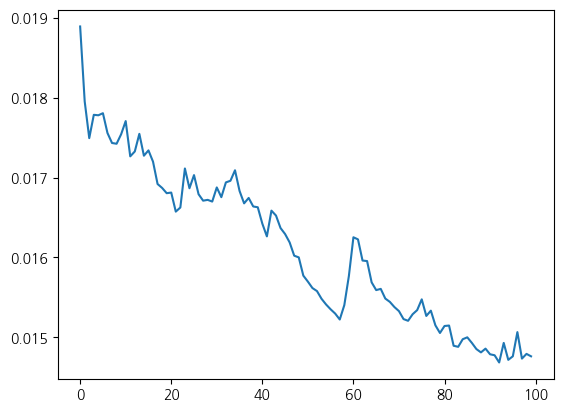

In [32]:
sns.lineplot(loss_list)

In [ ]:
torch.save(model, "VanillaRNN.pt")

In [35]:
# 커널 재실행 시 모델 불러오기
import torch

model = torch.load("VanillaRNN.pt")


In [44]:
# Validation 검증
from tqdm.auto import tqdm

model.eval()
with torch.no_grad():
    valid = []
    running_loss = 0.0
    n = len(valid_data_loader)
    valid_iterator = tqdm(enumerate(valid_data_loader), total=n, desc=f"validation")
    for _, batch_data in valid_iterator:
        X, y = batch_data
        valid_pred = model(X)
        valid += np.array(valid_pred).flatten().tolist()
    # inverse
    pred_inverse = y_scaler.inverse_transform(np.array(valid).reshape(-1, 1)).squeeze()
    y_valid = train.query("년도=='K'")["10분평균시정"].reset_index(drop=True)
    
    valid_df = pd.DataFrame({"actual" : y_valid,
                             "pred" : pred_inverse})
    
    # loss
    valid_df["loss"] = valid_df.apply(lambda x: round(float(criterion(torch.tensor(x.iloc[1], dtype=torch.float32), torch.tensor(x.iloc[0], dtype=torch.float32))), 2), axis=1)

validation:   0%|          | 0/7300 [00:00<?, ?it/s]

In [46]:
valid_df

,actual,pred,loss
0,20000.0,19968.606929,985.49
1,20000.0,19551.068135,201539.62
2,20000.0,19686.835027,98071.73
3,20000.0,19689.924860,96146.02
4,20000.0,19747.246415,63884.54
...,...,...,...
1051195,20000.0,19256.716840,552469.94
1051196,20000.0,19379.826778,384615.56
1051197,20000.0,19328.298887,451182.47
1051198,20000.0,19281.215450,516652.09


In [73]:
# 음수로 예측된 값 절대값 취함

valid_df["pred"] = valid_df["pred"].abs()

In [74]:
def make_class(vis):
    if 0 < vis and vis < 200 :
        return 1
    elif 200 <= vis and vis < 500 :
        return 2
    elif 500 <= vis and vis < 1000 :
        return 3
    elif 1000 <= vis :
        return 4
    else :
        return np.nan

In [75]:
valid_df["actual_target"] = valid_df["actual"].apply(make_class)
valid_df["pred_target"] = valid_df["pred"].apply(make_class)

In [76]:
valid_df.query("pred < 0")

,actual,pred,loss,actual_target,pred_target


In [93]:
valid_df.query("actual_target == 4").value_counts(subset="pred_target")

pred_target
4    1043029
3         20
2         14
1          9
Name: count, dtype: int64

In [77]:
valid_df.isna().sum()

actual           0
pred             0
loss             0
actual_target    0
pred_target      0
dtype: int64

In [83]:
valid_df.value_counts(subset="actual_target")

actual_target
4    1043072
2       3215
3       2996
1       1917
Name: count, dtype: int64

In [78]:
def csi_score_class(pred, actual):
    matrix = {i:{j:0 for j in range(1, 4+1)}for i in range(1, 4+1)}
    df_matrix = pd.DataFrame(matrix)
    # 길이가 같지 않으면 추론이 제대로 되지 않은 것이므로 에러 발생
    if len(pred) != len(actual):
        raise
    
    # 리스트로 들어온 pred와 actual을 순회하며 해당 class의 개수를 샘
    # 행이 pred, 열이 actual
    for i in range(len(pred)):
        df_matrix[pred[i]][actual[i]] += 1
    
    # H, F, M 배분
    H = df_matrix[1][1] + df_matrix[2][2] + df_matrix[3][3]
    F = sum(df_matrix.iloc[:, :3]) - H
    M = sum(df_matrix.iloc[:3, -1])
    
    return H / (H + F + M), df_matrix, (H, F, M)

In [79]:
score, csi_df, _ = csi_score_class(valid_df["pred_target"], valid_df["actual_target"])

In [80]:
score

0.0

In [94]:
# 행 index가 정답, 열 index가 예측
# 정답이 4인데 1로 예측한 것이 9개, 정답이 4인데 2로 예측한 것이 14개, 정답이 4인데 3으로 예측한 것이 20개 => 다 틀림
# 왜 이런 상황이 발생했을까? 1. Class imbalance 때문에?, 
csi_df

,1,2,3,4
1,0,0,0,1917
2,0,0,0,3215
3,0,0,0,2996
4,9,14,20,1043029


<Axes: ylabel='loss'>

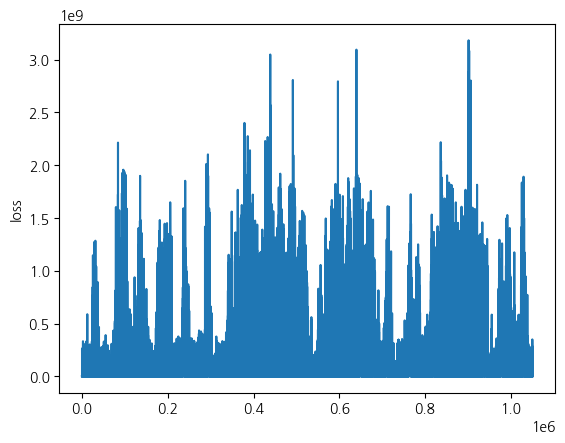

In [95]:
sns.lineplot(valid_df["loss"].astype(float))